In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
from sklearn.model_selection import train_test_split
from dataproc_utils import load_wordvecs, load_file, read_proc_data
from dataproc_utils import make_word_freq_V, word2idx
from dataproc_utils import vocab_vectorizer, random_sampler
from tfidf_cosine_similarity import tfidf_fit_transform

from keras.models import Model
import keras
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Reshape, Dropout
from keras.layers import dot, multiply, concatenate
from keras.layers import LSTM, Conv1D, TimeDistributed, Lambda
from keras.initializers import Constant
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Global variables

In [2]:
batch_size = 64
epochs = 15
random_state = 42
n_pars = 9 # max number of paragraphs from each document
par_size = 15  # max paragraph length (num of words in each paragraph)
claim_size = 15  # max num of words in each claim
embedding_dim = 100  # size of the pre-trained glove embeddings
output_size = 4  # size of the output vector, corresponds to the number of classes


# Embeddings from Glove

Only the words we use

In [3]:
# open saved wordvecs from file
w2v = load_wordvecs('twitter_glo_vecs\\train_wordvecs100d.txt')
print(len(w2v), 'pretrained embeddings')

# load data and labels
bodies_train = load_file('processed_data\\train_bodies.txt')
claims_train = load_file('processed_data\\train_claims.txt')
bodies_test = load_file('processed_data\\test_bodies.txt')
claims_test = load_file('processed_data\\test_claims.txt')

data_train = read_proc_data(bodies_train, claims_train, split_pars=True)
y_train = np.array([label for _, _, label in data_train])

data_test = read_proc_data(bodies_test, claims_test, split_pars=True)
y_test = np.array([label for _, _, label in data_test])

# train/validation split
train_data, val_data, train_labels, val_labels = train_test_split(data_train, y_train,
                                                                  test_size=.2,
                                                                  random_state=random_state)

# compute cos similarities after splitting into train/val or load the precomputed ones
# you have to recompute the similarities each time you change the random state of train/val split
# train_p_tfidf, val_p_tfidf, test_p_tfidf = tfidf_fit_transform(train_data, val_data, data_test)

# load pre-computed p_tfidf similarity matrix for train data
train_p_tfidf = np.loadtxt('processed_data\\p_tfidf_train.txt', dtype=np.float32)
val_p_tfidf = np.loadtxt('processed_data\\p_tfidf_val.txt', dtype=np.float32)
test_p_tfidf = np.loadtxt('processed_data\\p_tfidf_test.txt', dtype=np.float32)
print('Shape of similarity matrix train p_tfidf:', train_p_tfidf.shape)


# create a vocabulary dict from train data (we exclude rare words, which appear only once)
word2freq = make_word_freq_V(train_data, fmin=1)
word2index = word2idx(word2freq, pretrained=w2v)
vocab_size = len(word2index)
print('Vocab size:', vocab_size, 'unique words in the train set which have glove embeddings')

# vectorize input words (turn each word into its index from the word2index dict)
# for new words in test set that don't appear in train set, use index of <unknown>
train_body, train_claim = vocab_vectorizer(train_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
val_body, val_claim = vocab_vectorizer(val_data, word2index, max_par_len=par_size, max_claim_len=claim_size)
test_body, test_claim = vocab_vectorizer(data_test, word2index, max_par_len=par_size, max_claim_len=claim_size)

17354 pretrained embeddings
Shape of similarity matrix train p_tfidf: (39977, 9)
Vocab size: 17256 unique words in the train set which have glove embeddings


In [4]:
train_body.shape

(39977, 9, 15)

In [5]:
val_body.shape

(9995, 9, 15)

In [6]:
test_body.shape

(25413, 9, 15)

# Under sampling

In [7]:
# perform random under/over sampling to prevent class imbalance
train_body, train_claim, train_p_tfidf, train_labels = random_sampler(train_body,
                                                                      train_claim,
                                                                      train_p_tfidf,
                                                                      train_labels, type='under')

In [8]:
# perform random under/over sampling to prevent class imbalance
val_body, val_claim, val_p_tfidf, val_labels = random_sampler(val_body,
                                                              val_claim,
                                                              val_p_tfidf,
                                                              val_labels, type='under')

In [9]:
# perform random under/over sampling to prevent class imbalance
test_body, test_claim, test_p_tfidf, test_labels = random_sampler(test_body,
                                                                  test_claim,
                                                                  test_p_tfidf,
                                                                  y_test, type='under')

In [11]:
train_body.shape, val_body.shape, test_body.shape

((2640, 9, 15), (720, 9, 15), (2788, 9, 15))

In [12]:
# prepare embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for w, i in word2index.items():
    embedding_matrix[i] = w2v[w]

# Embeddings

In [13]:
# load pre-trained word vectors into embedding layers
# we set trainable to false to keep the embeddings fixed
embedding_body = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=(n_pars, par_size,),
                            trainable=False)

embedding_claim = Embedding(vocab_size + 1,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=claim_size,
                            trainable=False)

In [14]:
# initialize input placeholders and embed pre-trained word vectors
input_body = Input(shape=(n_pars, par_size,), dtype='int32', name='docs')
input_claim = Input(shape=(claim_size,), dtype='int32', name='claims')
input_p_tfidf = Input(shape=(n_pars,), dtype='float32', name='tfidf')

print('input body', input_body.shape)     # (?, 9, 15)
print('input claim', input_claim.shape)    # (?, 15)
print('input p_tfidf', input_p_tfidf.shape)  # (?, 9)

input body (?, 9, 15)
input claim (?, 15)
input p_tfidf (?, 9)


In [15]:
embedded_body = embedding_body(input_body)
embedded_claim = embedding_claim(input_claim)

print('embedded body', embedded_body.shape)   # (?, 9, 15, 25)
print('embedded claim', embedded_claim.shape)  # (?, 15, 25)

embedded body (?, 9, 15, 100)
embedded claim (?, 15, 100)


# CNNs

## Paragraphs

In [16]:
# train two 1D convnets (should be time distributed with maxout layer)
cnn_body = TimeDistributed(Conv1D(100, 5, padding='valid', activation='relu'), name='CNN_docs')(embedded_body)
cnn_body = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_docs')(cnn_body)  # this should be maxout
#cnn_body = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_body) ## does not work for some reason!!?

## Claims

In [17]:
cnn_claim = Conv1D(100, 5, padding='valid', activation='relu', name='CNN_claims')(embedded_claim)
cnn_claim = Lambda(lambda x: K.max(x, axis=-1, keepdims=False), name='CNN_maxout_claims')(cnn_claim)  # this should be maxout
#cnn_claim = Lambda(lambda x: tf.contrib.layers.maxout(x, num_units=1))(cnn_claim) ## does not work

For Maxout, we take the maximum value of the 100 values in the vector extracted by the CNN

In [18]:
# maxout eliminates the last dimension from the cnn representations:
# converts cnn_body with shape (?, 9, 11, 100) to (?, 9, 11)
# and cnn_claim with shape (?, 11, 100) to (?, 11)
print('cnn_body shape', cnn_body.shape)  # (?, 9, 11)
print('cnn_claim shape', cnn_claim.shape)  # (?, 11)

cnn_body shape (?, 9, 11)
cnn_claim shape (?, 11)


# LSTMs

- TimeDistributed for documents
- simple for claims

In [19]:
# train two lstms
lstm_body = TimeDistributed(LSTM(100), name="LSTM_docs")(embedded_body)
lstm_claim = (LSTM(100, name="LSTM_claims"))(embedded_claim)

print('lstm body', lstm_body.shape) # (?, 9, 100)
print('lstm claim', lstm_claim.shape) # (?, 100)

lstm body (?, 9, 100)
lstm claim (?, 100)


In [20]:
# reshape tfidf sim matrix layer from (?, 9) into (?, 9, 1)
reshaped_p_tfidf = Reshape((n_pars, 1), name="reshape_tfidf")(input_p_tfidf)
lstm_body = multiply([lstm_body, reshaped_p_tfidf], name="")
### tensor shapes: (samples, n_pars, 100) * (samples, n_pars, 1) => (?, 9, 100)
print('lstm_body * p_tfidf', lstm_body.shape)  # (?, 9, 100)

lstm_body * p_tfidf (?, 9, 100)


# P_lstm

In [21]:
## p_lstm = lstm_claim.T x M x lstm_body[j]  a.k.a. wtf is M?
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_lstm = dot([lstm_body, lstm_claim], axes=(2, 1), normalize=True, name="P_lstm")
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9)


In [22]:
### cnn_body = cnn_body * p_lstm
# reshape sim matrix layer from (?, 9) into (?, 9, 1)
p_lstm = Reshape((n_pars, 1), name="P_lstm_reshape")(p_lstm)

In [23]:
print('p_lstm', p_lstm.shape)  # (samples, 9)

p_lstm (?, 9, 1)


# P_cnn

In [24]:
cnn_body = multiply([cnn_body, p_lstm])
print('cnn_body * p_lstm', cnn_body.shape) # (?, 9, 11)
print('cnn_claim', cnn_claim.shape)        # (?, 11)

cnn_body * p_lstm (?, 9, 11)
cnn_claim (?, 11)


In [25]:
## p_cnn = cnn_claim.T x M' x cnn_body[j]  a.k.a. wtf is M'?
## if normalize=True, then the output of the dot product is the cosine similarity between the two samples
p_cnn = dot([cnn_body, cnn_claim], axes=(2, 1), normalize=True, name="P_cnn")
print('p_cnn', p_cnn.shape)  # (?, 9)

p_cnn (?, 9)


In [26]:
# no clue whats going from here onward
## o = [mean(cnn_body); [max(p_cnn); mean(p_cnn)]; [max(p_lstm); mean(p_lstm)]; [max(p_tfidf); mean(p_tfidf)]]
mean_cnn_body = Lambda(lambda x: K.mean(x, axis=2), name="mean_cnn_body")(cnn_body)
print('mean cnn body', mean_cnn_body.shape)  # (?, 9)

mean cnn body (?, 9)


# O

In [27]:
# taking mean and max similarities
max_p_cnn = Lambda(lambda x: K.max(x, axis=1), name="max_p_cnn")(p_cnn)
mean_p_cnn = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_cnn")(p_cnn)
max_p_lstm = Lambda(lambda x: K.max(x, axis=1), name="max_p_lstm")(p_lstm)
mean_p_lstm = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_lstm")(p_lstm)
max_p_tfidf = Lambda(lambda x: K.max(x, axis=1), name="max_p_tfidf")(reshaped_p_tfidf)
mean_p_tfidf = Lambda(lambda x: K.mean(x, axis=1), name="mean_p_tfidf")(reshaped_p_tfidf)

In [28]:
# reshape some layers to make their dimensions compatible
max_p_cnn = Reshape((1,), name="max_p_cnn_reshape")(max_p_cnn)
mean_p_cnn = Reshape((1,), name="mean_p_cnn_reshape")(mean_p_cnn)

In [29]:
output = concatenate([mean_cnn_body,
                      max_p_cnn, mean_p_cnn,
                      max_p_lstm, mean_p_lstm,
                      max_p_tfidf, mean_p_tfidf],
                    name="O_concatenate")

print('output', output.shape)  # (?, 15)

output (?, 15)


In [30]:
response = concatenate([output, lstm_claim, cnn_claim], name="input_for_dense_R")
print('response layer:', response.shape)   # (?, 126)

response layer: (?, 126)


In [31]:
# home stretch
stance = Dense(300, activation='relu', name="dense")(response)
stance = Dropout(0.3)(stance)
preds = Dense(output_size, activation='softmax')(stance)

In [32]:
# build the model
model = Model([input_body, input_claim, input_p_tfidf], preds)
model.compile(optimizer=keras.optimizers.adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Diagram of model

In [33]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Train

In [34]:
filepath="model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [35]:
# train
history = model.fit(
    [train_body, train_claim, train_p_tfidf], train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_body, val_claim, val_p_tfidf], val_labels),
    callbacks=[checkpoint]
         )

Train on 2640 samples, validate on 720 samples
Epoch 1/15
2640/2640 [==============================] - 7s 3ms/step - loss: 1.3582 - acc: 0.3265 - val_loss: 1.2688 - val_acc: 0.4444

Epoch 00001: val_acc improved from -inf to 0.44444, saving model to model.hdf5
Epoch 2/15
2640/2640 [==============================] - 2s 912us/step - loss: 1.1337 - acc: 0.5110 - val_loss: 1.0981 - val_acc: 0.5347

Epoch 00002: val_acc improved from 0.44444 to 0.53472, saving model to model.hdf5
Epoch 3/15
2640/2640 [==============================] - 2s 909us/step - loss: 0.9126 - acc: 0.6383 - val_loss: 1.0121 - val_acc: 0.5778

Epoch 00003: val_acc improved from 0.53472 to 0.57778, saving model to model.hdf5
Epoch 4/15
2640/2640 [==============================] - 2s 917us/step - loss: 0.7551 - acc: 0.7110 - val_loss: 0.9395 - val_acc: 0.6264

Epoch 00004: val_acc improved from 0.57778 to 0.62639, saving model to model.hdf5
Epoch 5/15
2640/2640 [==============================] - 2s 914us/step - loss: 0.59

In [42]:
test_claim.shape, y_test.shape

((2788, 15), (25413,))

In [37]:
preds = model.predict([test_body, test_claim, test_p_tfidf])

In [38]:
np.sum(preds[0])

1.0

# Confusion matrix

In [39]:
from sklearn.metrics import confusion_matrix


In [43]:
cnf_matrix = confusion_matrix(test_labels, np.argmax(preds,axis=1))

Normalized confusion matrix


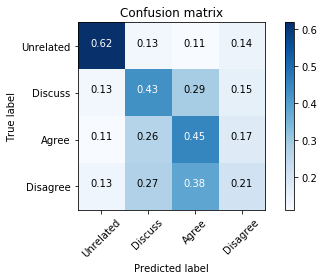

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

import itertools

fig = plot_confusion_matrix(cnf_matrix, ['Unrelated','Discuss','Agree','Disagree'], normalize=True)


# Plot training

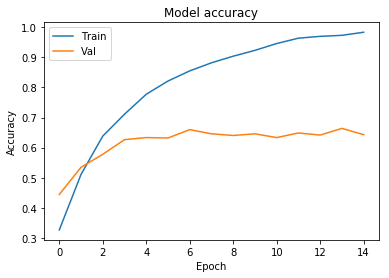

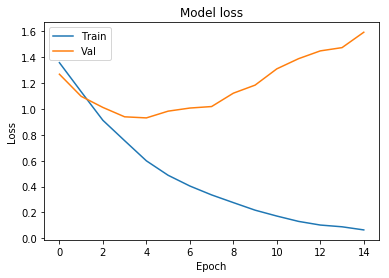

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Exploring model layers

In [ ]:
index2word = {index:word for word,index in word2index.items()}

In [ ]:
index2word[0] = ''

In [ ]:
NR_ENTRY = 2

one_input = [[val_body[NR_ENTRY]], [val_claim[NR_ENTRY]], [val_p_tfidf[NR_ENTRY]]]

p_cnn_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('P_cnn').output)

p_cnn_pred = p_cnn_layer_model.predict(one_input)

most_sim_paragraph_index = p_cnn_pred.argmax()

most_sim_paragraph = [index2word[w] for w in one_input[0][0][most_sim_paragraph_index]]

# Full body
#[[index2word[w] for w in one_input[0][0][i]] for i in range(9)]

print("claim: ", [index2word[w] if w!=0 else 0 for w in one_input[1][0]])

cnn_maxout_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('CNN_maxout_docs').output)

cnn_maxout_pred = cnn_maxout_layer_model.predict(one_input)

cnn_maxout_pred.shape

ngramindex = cnn_maxout_pred[0][most_sim_paragraph_index].argmax()

print("most sim ngram: ", most_sim_paragraph[ngramindex:ngramindex+5])
print("most sim paragraph: ", most_sim_paragraph)

print("stance: ", model.predict(one_input).argmax())

```
    df.loc[df['Stance'] == 'unrelated', 'Stance'] = 0
    df.loc[df['Stance'] == 'discuss', 'Stance'] = 1
    df.loc[df['Stance'] == 'agree', 'Stance'] = 2
    df.loc[df['Stance'] == 'disagree', 'Stance'] = 3
    ```

In [ ]:
NR_ENTRY = 401, 409

In [ ]:
make_sense = [310, 220, 3105]